In [19]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import dataloader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
from torch.utils.tensorboard import SummaryWriter

In [20]:
class Discriminator(nn.Module):
    def __init__(self,imgsize):
        super().__init__()
        self.dis= nn.Sequential(
            nn.Linear(imgsize,128),
            nn.LeakyReLU(0.1),
            nn.Linear(128,1),
            nn.Sigmoid()
        )

    def forward(self,x):
      return self.dis(x)

class Generator(nn.Module):
    def __init__(self,noisesize,imgsize):
        super().__init__()
        self.enc= nn.Sequential(
            nn.Linear(noisesize,256),
            nn.LeakyReLU(0.1),
            nn.Linear(256,imgsize),
            nn.Tanh()
        )

    def forward(self,x):
      return self.enc(x)

In [21]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr=3e-4
noisedim=64
imagedim=28*28
batchsize=64
epochs=50

In [22]:
disc= Discriminator(imagedim).to(device)
gen= Generator(noisedim,imagedim).to(device)
fixednoise=torch.randn(batchsize,noisedim).to(device)

transforms= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
dataset= datasets.MNIST(root='./data',train=True,transform=transforms,download=True)
dataloader= torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=True)

opt_disc= optim.Adam(disc.parameters(),lr=lr)
opt_gen= optim.Adam(gen.parameters(),lr=lr)
criterion= nn.BCELoss()

In [23]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [31]:
lossDacg=0
lossGacg=0
for epoch in range(20):

  for (bid,(img,_)) in enumerate(dataloader):

    #Discriminator training
    real=img.view(-1,imagedim).to(device)
    noise= torch.randn(batchsize,noisedim).to(device)
    fake= gen(noise)
    disc_real=disc(real).view(-1)
    lossD_real= criterion(disc_real,torch.ones_like(disc_real))
    disc_fake=disc(fake).view(-1)
    lossD_fake= criterion(disc_fake,torch.zeros_like(disc_fake))
    lossD= (lossD_real+lossD_fake)/2
    lossDacg+=lossD.item()
    disc.zero_grad()
    lossD.backward(retain_graph=True)
    opt_disc.step()

    #Generator Training

    out=disc(fake).view(-1)
    lossG= criterion(out,torch.ones_like(out))
    lossGacg+=lossG.item()
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    if bid==0:
      print(f'Epoch {epoch} Loss D: {lossDacg/len(dataloader)} Loss G: {lossGacg/len(dataloader)}')
      lossDacg=0
      lossGacg=0

      with torch.no_grad():
        fake=gen(fixednoise).reshape(-1,1,28,28)
        real=real.reshape(-1,1,28,28)

        img_grid_fake= torchvision.utils.make_grid(fake,normalize=True)
        img_grid_real= torchvision.utils.make_grid(real,normalize=True)

        show([img_grid_fake,img_grid_real])


Output hidden; open in https://colab.research.google.com to view.

In [32]:
torch.save(disc.state_dict(),'disc.pth')
torch.save(gen.state_dict(),'gen.pth')

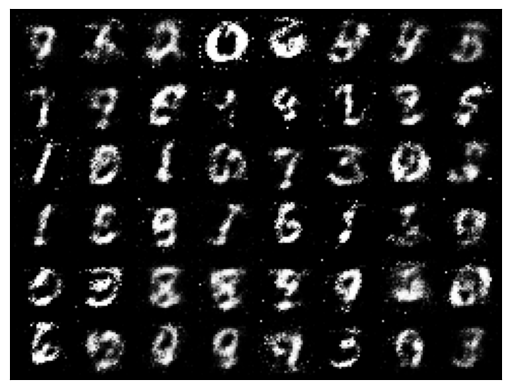

In [52]:
random= torch.randn(48,noisedim).to(device)
fake= gen(random).reshape(-1,1,28,28)
img_grid_fake= torchvision.utils.make_grid(fake,normalize=True)
show(img_grid_fake)